# Проектная практика: загрузка модели из HF и её использование

## Импорты


In [1]:
import pandas as pd
import numpy as np

from huggingface_hub import hf_hub_download
import joblib

import catboost
from sklearn.metrics import root_mean_squared_error

from bloxs import B
import plotly.graph_objects as go

## Вспомогательный функционал

In [2]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df.sort_values(by='feature_importance', ascending=True)

    fig = go.Figure(data=[
        go.Bar(
            x=fi_df['feature_importance'],
            y=fi_df['feature_names'],
            orientation='h',
            text=fi_df['feature_importance'].round(3),
            textposition='outside'
        )
    ])

    fig.update_layout(
        title=model_type + ' feature importance',
        xaxis_title='Feature Importance',
        yaxis_title='',
        showlegend=False,
        height=600
    )

    return fig

## Загрузка валидационной выборки
Валидационная выборка содержит 50 наблюдений для симуляций со следующими параметрами:
- `beta` - коэффициент инфективности патогена в диапазоне `[0.01, 0.09, 0.17, 0.25]`;
- `pollutant_immunity_reduction` - коэффициент снижения иммунитета у агентов, подверженных загрязнению, в диапазоне `[0, 0.1, 0.2, 0.3]`;
- `initially_infected` - количество изначально заражённых агентов в диапазоне `[4, 6, 8, 10]`;
- `lowest_immunity` - минимально возможный иммунитет агента `[0.1, 0.2, 0.3]`;
- `highest_immunity` - максимально возможный иммунитет агента `[0.6 , 0.75, 0.9]`;
- `mask_beta_penalty` - снижение инфективности при применении маски `[0.25, 0.5]`;
- `seed` - random seed значение симуляции;
- `n_agents` - количество агентов в симуляции = 10000;
- `exposed_to_pollutant` - количество агентов, подверженных в симуляции загрязнению, = 2458.


Скачаем выборку из репозитория "[Влияние загрязнений на количество инфицированных в агентной модели распространения инфекционных заболеваний](https://github.com/AlekseiAgarkov/MIFIML-2-Sem1-M25-525-Project-Practice)".


In [3]:
csv_url = "https://raw.githubusercontent.com/AlekseiAgarkov/MIFIML-2-Sem1-M25-525-Project-Practice/refs/heads/main/data/project_practice_20251214.csv"
val_df = pd.read_csv(csv_url)
val_df.head()

,simulation_id,random_seed,n_agents,exposed_to_pollutant,exposed_to_pollutant_share,sim_duration,initially_infected,lowest_immunity,highest_immunity,mask_beta_penalty,...,recovered_330d,infected_360d,exposed_360d,recovered_360d,max_infected,max_exposed,max_recovered,total_infected,total_exposed,total_recovered
0,2a37caa,3272,10000,2458,0.2458,365,6,0.3,0.9,0.25,...,9997,9997,9991,9997,1207,548,9997,9997,9991,9997
1,c68c942,3292,10000,2458,0.2458,365,10,0.2,0.6,0.25,...,2694,3476,3609,3155,328,152,3234,3548,3689,3234
2,86583a3,3249,10000,2458,0.2458,365,8,0.3,0.9,0.25,...,10000,10000,9992,10000,2163,954,10000,10000,9992,10000
3,4d7d83d,3252,10000,2458,0.2458,365,8,0.2,0.9,0.25,...,10000,10000,9992,10000,2279,1013,10000,10000,9992,10000
4,18bee1e,3245,10000,2458,0.2458,365,6,0.3,0.6,0.50,...,10000,10000,9994,10000,1304,597,10000,10000,9994,10000


## Загрузка моделей
Загрузим предобученные модели:
- [20251214-agentic_disease_spread_catboost_pollutant-infected_90d](https://huggingface.co/agarkov-aleksei1/20251214-agentic_disease_spread_catboost_pollutant-infected_90d) - модель, в которой учитывается эффект от загрязнителя;
- [20251214-agentic_disease_spread_catboost_pollutant_with_beta-infected_90d](https://huggingface.co/agarkov-aleksei1/20251214-agentic_disease_spread_catboost_pollutant_with_beta-infected_90d) - модель, в которой учитывается эффект от загрязнителя и параметр инфективности $\beta$.

### pollutant
`pollutant_model` - модель, в которой учитывается эффект от загрязнителя.

In [4]:
pollutant_model_path = hf_hub_download(
    repo_id="agarkov-aleksei1/20251214-agentic_disease_spread_catboost_pollutant-infected_90d",
    filename="agentic_disease_spread_catboost_pollutant.joblib"
)
pollutant_model = joblib.load(pollutant_model_path)

agentic_disease_spread_catboost_pollutan(…):   0%|          | 0.00/86.2k [00:00<?, ?B/s]

In [5]:
pollutant_model.best_score_

{'learn': {'RMSE': 2256.113690133187},
 'validation': {'RMSE': 2369.686906366748}}

### pollutant + $\beta$
`pollutant_with_beta_model` - модель, в которой учитывается эффект от загрязнителя и параметр инфективности $\beta$.

In [6]:
pollutant_with_beta_model_path = hf_hub_download(
    repo_id="agarkov-aleksei1/20251214-agentic_disease_spread_catboost_pollutant_with_beta-infected_90d",
    filename="agentic_disease_spread_catboost_pollutant_with_beta.joblib"
)
pollutant_with_beta_model = joblib.load(pollutant_with_beta_model_path)

agentic_disease_spread_catboost_pollutan(…):   0%|          | 0.00/141k [00:00<?, ?B/s]

In [7]:
pollutant_with_beta_model.best_score_

{'learn': {'RMSE': 476.4099269881833},
 'validation': {'RMSE': 535.5501316646842}}

## Подготовка выборок
Подготовим выборки.

### pollutant
Выборка для модели `pollutant_model`.

In [8]:
pollutant_X = val_df[pollutant_model.feature_names_]
pollutant_y = val_df['infected_90d']

### pollutant + $\beta$
Выборка для модели `pollutant_with_beta_model`.

In [9]:
pollutant_with_beta_X = val_df[pollutant_with_beta_model.feature_names_]
pollutant_with_beta_y = val_df['infected_90d']

## Оценка качества прогнозов

### ☣️: Pollutant

In [10]:
pollutant_preds = pollutant_model.predict(pollutant_X)
pollutant_rmse = round(root_mean_squared_error(pollutant_y, pollutant_preds), 2)

### ☣️ + 🤒: Pollutant + $\beta$

In [11]:
pollutant_with_beta_preds = pollutant_with_beta_model.predict(pollutant_with_beta_X)
pollutant_with_beta_rmse = round(root_mean_squared_error(pollutant_with_beta_y, pollutant_with_beta_preds), 2)

### Сравнение

In [12]:
B([B(pollutant_rmse, "Prediction RMSE<br><b>☣️Pollutant☣️</b>"),
   B(pollutant_with_beta_rmse, "Prediction RMSE<br><b>☣️Pollutant☣️ + 🤒β🤒</b>")])

## Интерпретация
Модель `pollutant_model` имеет очень высокий RMSE ($\pm2378.38$ инфицированных к 90-му дню симуляций на 10000 агентов), что говорит о низкой предсказательной силе выбранной для обучения совокупности факторов (`initially_infected`, `lowest_immunity`, `highest_immunity`, `mask_beta_penalty`, `pollutant_immunity_reduction`).

Стоит отметить, что фактор, влияние которого мы рассматриваем, в целом, в модели на последнем месте по значимости.

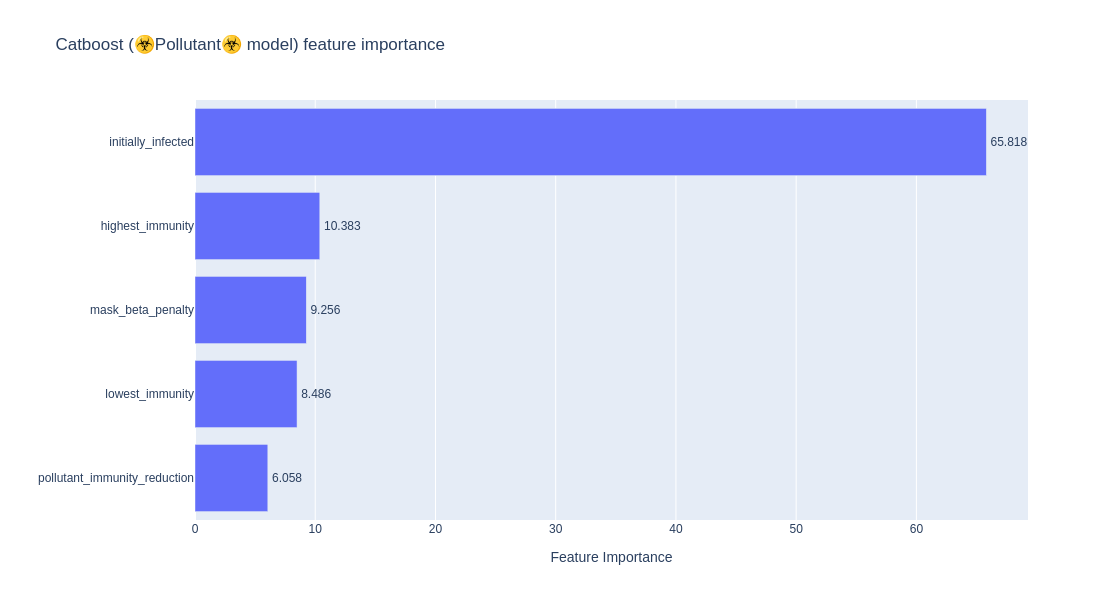

In [13]:
plot_feature_importance(importance=pollutant_model.get_feature_importance(),
                        names=pollutant_model.feature_names_,
                        model_type="Catboost (☣️Pollutant☣️ model)")

In [14]:
pollutant_with_beta_model.feature_names_

['beta',
 'initially_infected',
 'lowest_immunity',
 'highest_immunity',
 'mask_beta_penalty',
 'pollutant_immunity_reduction']

Модель `pollutant_with_beta_model` имеет RMSE $\pm 567,63$ инфицированных к 90-му дню симуляций на 10000 агентов. Этот результат лучше, чем у модели `pollutant_model`. В этом случае, значимость `pollutant_immunity_reduction` в совокупности факторов (`beta`, `initially_infected`, `lowest_immunity`, `highest_immunity`, `mask_beta_penalty`, `pollutant_immunity_reduction`) снижилась ещё сильнее.

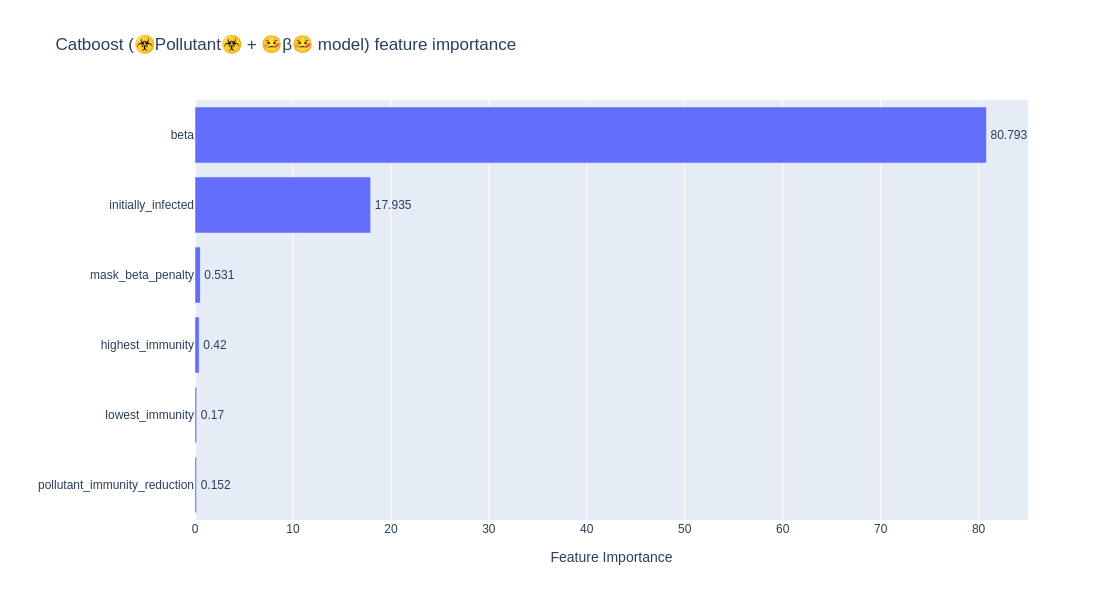

In [15]:
plot_feature_importance(importance=pollutant_with_beta_model.get_feature_importance(),
                        names=pollutant_with_beta_model.feature_names_,
                        model_type="Catboost (☣️Pollutant☣️ + 🤒β🤒 model)")

Рассмотрев параметры симуляции, такая картина на будет сюрпризом, ведь `beta` (коэффициент инфективности патогена) при оценке вероятности заражения от инфицированных соседей [суммируется](https://github.com/AlekseiAgarkov/AgenticInfectiousDiseaseTransmissionModels/blob/main/src/models/seir.py#L234):

```python
neighbor_infect_probability = sum(n.probability_to_infect() for n in self.neighbors)
```
А сама вероятность заразить $P_{to\_infect}(A_i(t))$ строится следующим образом:
$$P_{to\_infect}(A_i(t))=\beta_{A_i} \cdot I_{A}(t) \cdot (1 - M_{\beta\ penalty} \cdot M(A_i(t)),\ \beta_{A_i}
\in [0, 1], \ I_{A}(t) \in \mathbb{B},\ M_{penalty} \in [0, 1],\ M(A_i(t)) \in \mathbb{B}$$

- $P_{to\_infect}(A_i(t))$ - Вероятность агента $i$ заразить своего соседа в момент времени $t$;
- $\beta_{A_i}$ - $\beta$ параметр для агента $i$;
- $I_{A}(t)$ - статус инфицированности, т.е. является ли агент $i$ инфицированным;
- $M_{\beta\ penalty}$ - коэффициент снижения $\beta$ при ношении маски во время контакта;
- $M(A_i(t))$ - носит ли агент $i$ маску при контакте с другим агентом во время $t$.

При рассмотрении [связи вероятности заражения и иммунитета](https://github.com/AlekseiAgarkov/AgenticInfectiousDiseaseTransmissionModels/blob/main/src/models/seir.py#L235), мы увидим что загрязнитель снижает иммунитет, но это, судя по результатам обучения и сравнения качества моделей имеет малое значение:
```python
self.exposition_coeff = (1.0 - self.pollutant_immunity_reduction * self.exposed_to_pollutant)
...
def current_immunity(self, decimals: int = 2) -> float:
        current_day_immunity = immunity_by_year_day(day=self.env.now,
                                                    low=self.immunity_lower_bound,
                                                    high=self.immunity_upper_bound)

        return round(current_day_immunity * self.exposition_coeff, decimals)
```

Важно отметить и то, что:
- количество агентов, подверженных в симуляции загрязнению составляет 2458 или 24,58% от общей популяции агентов;
- параметр снижения иммунитета в симуляциях для формирования обучающей выборки принимал значения $[0, 0.1, 0.2, 0.3]$.

## Возможная дальнейшая работа

Для улучшения качества моделей можно предпринять следующие меры:
- провести больше симуляций, варьируя:
  - количество агентов, подверженных загрязнению;
  - коэффициент `pollutant_immunity_reduction`;
  - количество соседей;
- провести оптимизацию гиперпараметров.

## Выводы
При помощи симулятора [Agent-based Implementations for Infectious Disease Transmission Models](https://github.com/AlekseiAgarkov/AgenticInfectiousDiseaseTransmissionModels) было проведено 2000 симуляций. На полученных данных было обучено 2 регрессионных модели с использованием  CatboostRegressor.

При помощи валидационной выборки, сгенерированной на параметрах обучающей выборки, было выяснено, что модель `pollutant_model` имеет очень высокий RMSE ($\pm2378.38$ инфицированных к 90-му дню симуляций на 10000 агентов), а модель `pollutant_with_beta_model` имеет RMSE ±567,63. В обеих моделях значимость целевого исследуемого фактора `pollutant_immunity_reduction` оказалась не высока.

Важно отметить, что данный сценарий является лишь одним из множества аналитических сценариев "What if?". Разработанный функционал и проведённое исследование послужит основой для формирования методологии "What if?" анализа с применением симулятора агентных моделей распространения инфекционных заболеваний.

Система демонстрирует потенциал для исследования, учитывает гетерогенность популяции и динамику контактов. Перспективы развития проекта связаны с валидацией модели на реальных данных, оптимизацией её производительности и дальнейшим расширением (например, взаимодействие с системой здравоохранения).